In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import pyspherical as pysh
from pycbc.types import TimeSeries
from pycbc.filter import overlap_cplx
from pycbc.psd import aLIGOZeroDetHighPower
from lalsimulation import SimAddMode
import EOBRun_module

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

In [2]:
def gen_teob(modes, phase, inc):

    # Generate waveform
    mode_lm_gen = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]
    f_avg = 10*(1+0.2**2)/(1-0.2**2)**(3/2)
    pars = {
        'M': 60,
        'q': 2,
        'chi1': 0,
        'chi2': 0,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': 0.2,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': 4096,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm_gen,
        'arg_out': "yes",
        'distance': 1.0,
        'coalescence_angle': phase,
        'inclination': inc,
    }
    t, hp, hc, hlm, _ = EOBRun_module.EOBRunPy(pars)
    if [2, 2] in modes:
        t_mode = '1'
    else:
        t_mode = str(mode_lm_gen[0])
    tmrg = t[np.argmax(hlm[t_mode][0])]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])
    h = hp - 1j*hc
    hlms = {}
    for i, lm in enumerate(mode_lm_gen):
        lm_str = str(modes[i][0]) + str(modes[i][1])
        lm_p = hlm[str(lm)][0]*np.cos(hlm[str(lm)][1])
        lm_c = hlm[str(lm)][0]*np.sin(hlm[str(lm)][1])
        lm_p = TimeSeries(lm_p, t[1] - t[0], epoch=t[0])
        lm_c = TimeSeries(lm_c, t[1] - t[0], epoch=t[0])
        hlms[lm_str] = lm_p - 1j*lm_c

    return h, hlms    

In [3]:
h, hlms = gen_teob([[2, 2], [3, 3], [4, 4], [2, 1], [3, 2]], 1.75, 0.75)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


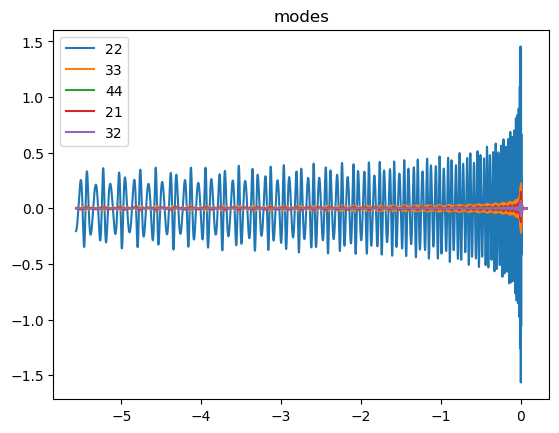

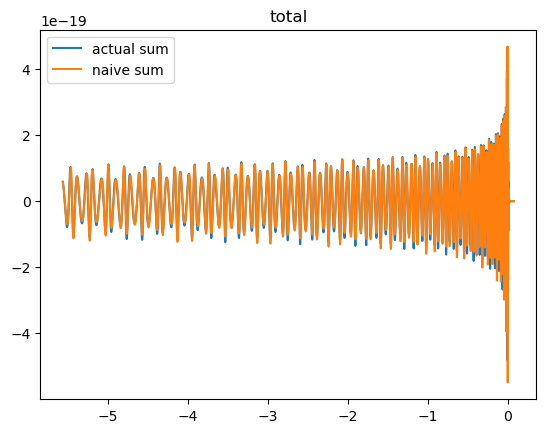

In [4]:
plt.show()
plt.title('modes')
total_hlm = hlms['22'].copy()
for lm in hlms.keys():
    plt.plot(hlms[lm].sample_times, hlms[lm], label=lm)
    if lm != '22':
        total_hlm += hlms[lm]
plt.legend()
plt.show()
plt.plot(h.sample_times, h, label='actual sum')
ang_fix = np.e**(1j*(np.angle(h[0]) - np.angle(total_hlm[0])))
plt.plot(total_hlm.sample_times, ang_fix*total_hlm*np.mean(np.abs(h))/np.mean(np.abs(total_hlm)), label='naive sum')
plt.title('total')
plt.legend()

The individual modes outputted by TEOBResumS-Dali do not have the correct normalisation factors with respect to each other to be added together simply to get the total waveform.

We will try here to work out the correct factors to use to recover the actual sum.

In [5]:
def compare_sum(h, new_sum):
    
    # Calculate overlap
    try:
        psd = aLIGOZeroDetHighPower(len(h)//2 + 1, 1.0 / h.duration, 10)
        ovlp = np.abs(overlap_cplx(h.real(), new_sum.real(), psd=psd, low_frequency_cutoff=10, high_frequency_cutoff=2048))
        print(f'Overlap: {ovlp}')
    except ZeroDivisionError:
        print('Overlap failed as one or more of the waveforms is zero')
    
    # Plot formatting
    plt.figure(figsize=(6.4*3, 4.8))
    x_low, x_high = -5, -4
    plot_inds = (h.sample_times>=x_low)*(h.sample_times<=x_high)
    maxy = np.max(np.abs(h[plot_inds]))
    
    # Plot amplitude comparison
    plt.subplot(1, 3, 1)
    plt.plot(h.sample_times, np.abs(h), label='actual sum')
    plt.plot(new_sum.sample_times, np.abs(new_sum), label='new sum')
    plt.title('amplitude')
    plt.xlabel('Time to coalescence / s')
    plt.xlim(x_low, x_high)
    plt.ylim(0, maxy*1.3)
    plt.legend()
    
    # Plot plus comparison
    plt.subplot(1, 3, 2)
    plt.plot(h.sample_times, h.real(), label='actual sum')
    plt.plot(new_sum.sample_times, new_sum.real(), label='new sum')
    plt.title('plus')
    plt.xlabel('Time to coalescence / s')
    plt.xlim(x_low, x_high)
    plt.ylim(-maxy*1.3, maxy*1.3)
    plt.legend()
    
    # Plot cross comparison
    plt.subplot(1, 3, 3)
    plt.plot(h.sample_times, h.imag(), label='actual sum')
    plt.plot(new_sum.sample_times, new_sum.imag(), label='new sum')
    plt.title('cross')
    plt.xlabel('Time to coalescence / s')
    plt.xlim(x_low, x_high)
    plt.ylim(-maxy*1.3, maxy*1.3)
    plt.legend()

In [6]:
def sum_modes(h, hlms, theta, iota):
    hp = TimeSeries(np.zeros_like(h.real()), h.delta_t, h.start_time).lal()
    hc = TimeSeries(np.zeros_like(h.imag()), h.delta_t, h.start_time).lal()
    for lm in hlms.keys():
        hmode = (-hlms[lm]).copy().lal()
        SimAddMode(hp, hc, hmode, iota, np.pi/2 - theta, int(lm[0]), int(lm[1]), 1)
    total = TimeSeries(hp.data.data - 1j*hc.data.data, h.delta_t, h.start_time)
    total *= np.mean(np.abs(h)/np.abs(total))
    return total

Overlap: 1.0


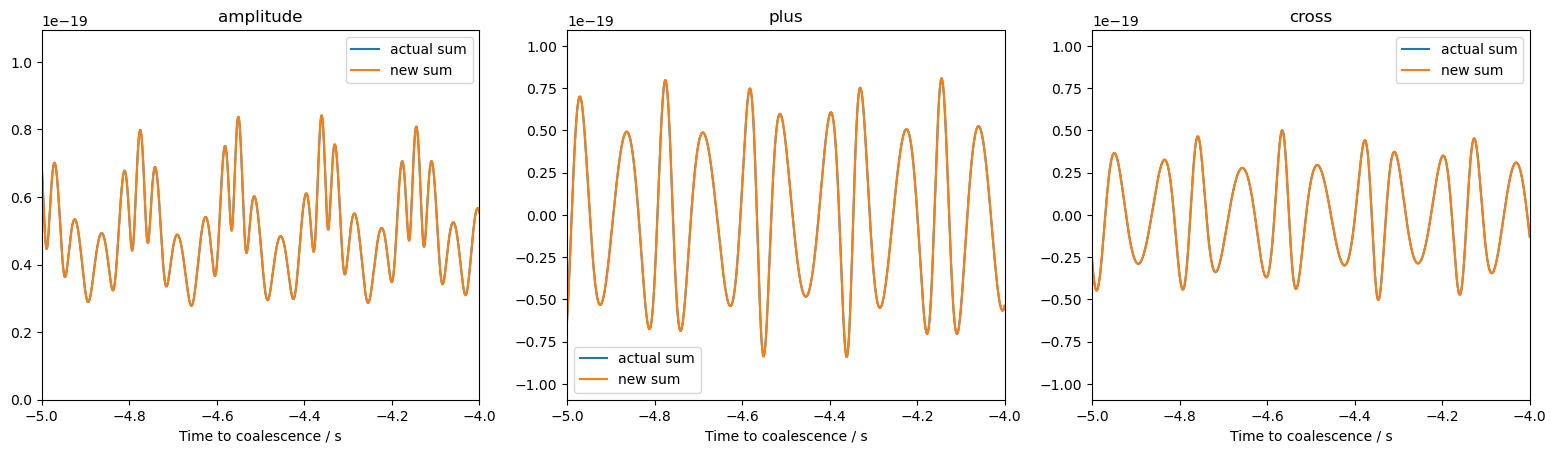

In [7]:
modes = [[2, 2], [3, 3], [4, 4], [2, 1], [3, 2]]
phase = 0.7
inc = 1.9
h, hlms = gen_teob(modes, phase, inc)
new_sum = sum_modes(h, hlms, phase, inc)
compare_sum(h, new_sum)

We have done it!

In [8]:
from simple_pe.waveforms import generate_eccentric_waveform

lal.MSUN_SI != Msun


(-2e-19, 2e-19)

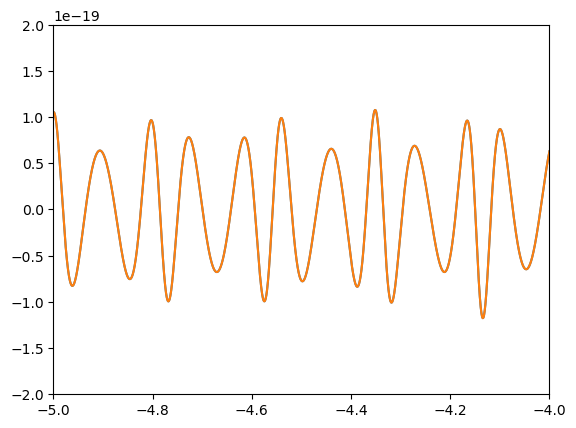

In [11]:
hp, hc = generate_eccentric_waveform(
    60, 2, 0.2, 0, 0, 10, 4096, phase=1.857564, inclination=5.452342,
    distance=1, f_ref_e=None, tlen=32, taper=True, to_fs=False,
    mode_array=[[2, 2], [3, 3], [4, 4]], align_merger=True, use_22_merger_time=True,
    separate_lms=False
)

hps, hcs = generate_eccentric_waveform(
    60, 2, 0.2, 0, 0, 10, 4096, phase=1.857564, inclination=5.452342,
    distance=1, f_ref_e=None, tlen=32, taper=True, to_fs=False,
    mode_array=[[2, 2], [3, 3], [4, 4]], align_merger=True, use_22_merger_time=True,
    separate_lms=True
)

plt.plot(hp.sample_times, hp)
total = TimeSeries(np.zeros_like(hp), hp.delta_t, hp.start_time)
for hp in hps:
    total += hp
plt.plot(total.sample_times, total)
plt.xlim(-5, -4)
plt.ylim(-2e-19, 2e-19)